In [12]:
import pandas as pd 
from deepfake_detection.defaults import TEST_OUT_PATH
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

In [13]:
test_results_file_b7 = "/home/faraz/Documents/code/deepfake_detection/experiment_outputs/justify_baseline_b7__b7/justify_baseline_b7__b7.csv"
test_results_file_b4 = "/home/faraz/Documents/code/deepfake_detection/experiment_outputs/baseline_experiment__b4/baseline_experiment__b4.csv"

In [21]:
# test_df = pd.read_csv(TEST_OUT_PATH / test_results_file)
test_df = pd.read_csv(test_results_file_b7)

In [22]:
ground_truth = test_df['ground_truth'].to_numpy()
predictions = test_df['predictions'].to_numpy()

In [23]:
ground_truth

array([1., 1., 1., ..., 1., 0., 0.])

In [24]:
predictions

array([0.96909374, 0.99188083, 0.99043906, ..., 0.72152787, 0.7993077 ,
       0.3911494 ])

In [25]:
def find_precision_threshold(predictions, ground_truth, target_precision=0.99):
    lower_bound = 0
    upper_bound = 1
    precision = 0
    threshold = 0.5 
    
    while lower_bound < upper_bound:
        threshold = (lower_bound + upper_bound) / 2
        thresh_predictions = predictions > threshold
        precision = precision_score(ground_truth, thresh_predictions)

        if precision < target_precision:
            lower_bound = threshold
        else:
            upper_bound = threshold
        
        if upper_bound - lower_bound < 1e-5:
            break

    while precision < target_precision:
        threshold += 1e-5
        thresh_predictions = predictions > threshold
        precision = precision_score(ground_truth, thresh_predictions)
    
    return threshold

THRESHOLD = find_precision_threshold(predictions, ground_truth)
THRESHOLD

0.8417229516601562

In [26]:
thresh_predictions = predictions > THRESHOLD
ground_truth = ground_truth == 1

In [27]:
accuracy = accuracy_score(ground_truth, thresh_predictions)
precision = precision_score(ground_truth, thresh_predictions)
recall = recall_score(ground_truth, thresh_predictions)
f1 = f1_score(ground_truth, thresh_predictions)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}")

num_fake = np.sum(ground_truth)
num_real = len(ground_truth) - num_fake
print(f"Count Fake = {num_fake}, Count Real = {num_real}")

Accuracy: 0.8514811515117768, Precision: 0.990019834398514, Recall: 0.7523326474950954, F1: 0.8549639075053358
Count Fake = 41798, Count Real = 30038


/home/faraz/.cache/pypoetry/virtualenvs/deepfake-detection-luHkh4Hu-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


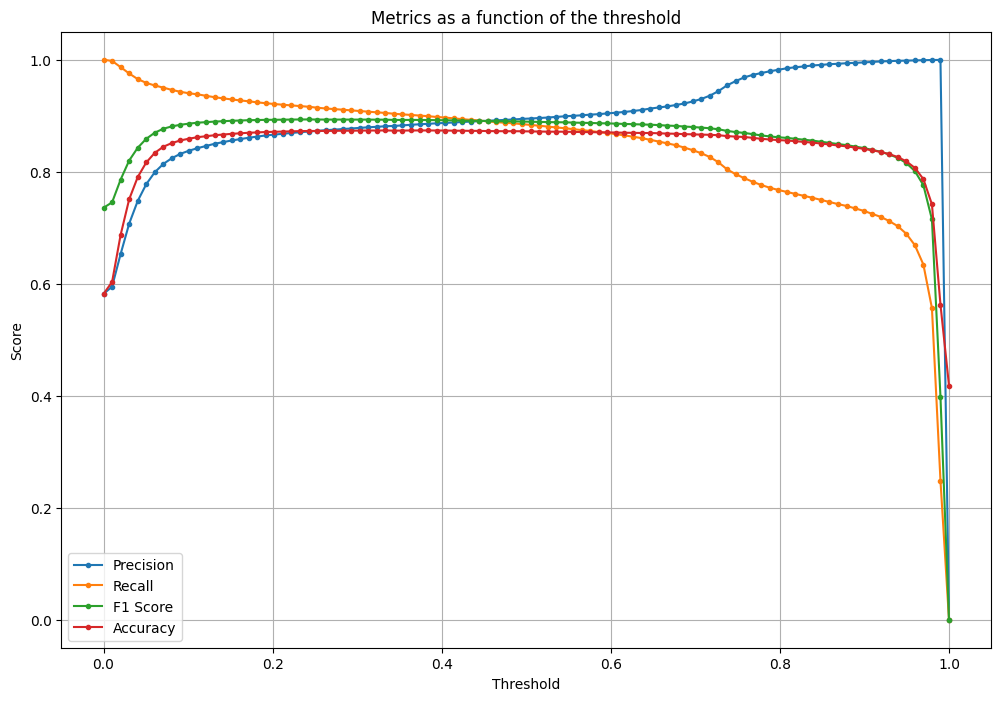

In [11]:
precisions = []
recalls = []
f1_scores = []
accuracies = []

thresholds = np.linspace(0, 1, 100)

for threshold in thresholds:
    thresh_predictions = predictions > threshold
    accuracy = accuracy_score(ground_truth, thresh_predictions)
    precision = precision_score(ground_truth, thresh_predictions)
    recall = recall_score(ground_truth, thresh_predictions)
    f1 = f1_score(ground_truth, thresh_predictions)
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

plt.figure(figsize=(12, 8))
plt.plot(thresholds, precisions, label='Precision', marker='.')
plt.plot(thresholds, recalls, label='Recall', marker='.')
plt.plot(thresholds, f1_scores, label='F1 Score', marker='.')
plt.plot(thresholds, accuracies, label='Accuracy', marker='.')
plt.title('Metrics as a function of the threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()